Paper: [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

In [ ]:
!pip -q install torchinfo
!pip -q install torchview

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

from torchinfo import summary
from torchview import draw_graph

# Hyperparameters

In [ ]:
# Model Hyperparameters
NUM_EPOCHS = 6800
LEARNING_RATE = 0.001

ALPHA = 1
BETA = 0.01

# Image config
# IMAGE_SIZE = 356
IMAGE_SIZE = 224

# H/W Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper Function

In [ ]:
loader = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.40], std=[0.229, 0.224, 0.225])
])

In [ ]:
def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(DEVICE)

# Model

In [ ]:
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
print(model)

# model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)
# # model_graph.visual_graph.render(format='png', filename='model_graph')
# model_graph.visual_graph

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 71.1MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ['0', '5', '10', '19', '28']
        self.model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features[:29] # Get layer from 0 to 28

    def forward(self, x):
        features = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

# Load Image

In [ ]:
!wget -q "https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/Raima_Sen_%28cropped%29.jpg/960px-Raima_Sen_%28cropped%29.jpg" -O "source.jpg"

!wget -q "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/500px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg" -O "style.jpg"

In [ ]:
original_image = load_image("source.jpg")
style_image = load_image("style.jpg")

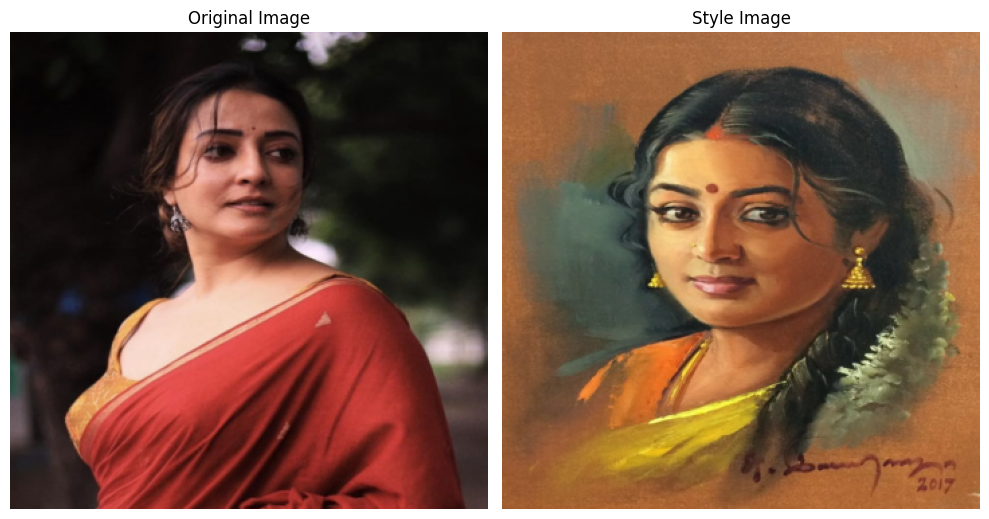

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(original_image.squeeze(0).permute(1, 2, 0).cpu())
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(style_image.squeeze(0).permute(1, 2, 0).cpu())
ax[1].set_title("Style Image")
ax[1].axis("off")

plt.tight_layout()
plt.show()

# Tranning Loop

In [ ]:
# generated = torch.randn(original_image.shape, device=DEVICE, requires_grad=True)
generated = original_image.clone().requires_grad_(True)

In [ ]:
model = VGG().to(DEVICE).eval()

In [ ]:
optimizer = optim.Adam([generated], lr=LEARNING_RATE)

In [ ]:
import os

# Check if the directory exists before creating it
if not os.path.exists("output"):
    os.mkdir("output")

In [ ]:
for epoch in range(NUM_EPOCHS):
    generated_features = model(generated)
    original_image_features = model(original_image)
    style_image_features = model(style_image)

    style_loss = original_loss = 0

    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_image_features, style_image_features
    ):
        batch_size, channel, height, width = gen_feature.shape

        original_loss += torch.mean((gen_feature - orig_feature) ** 2)

        # compute gram matrix
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = ALPHA * original_loss + BETA * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Total Loss: {total_loss}")
        save_image(generated, os.path.join('output', f"generated_{epoch}.png"))

    # print("Epoch: {} | Total Loss: {}".format(epoch, total_loss))

Epoch: 0 | Total Loss: 87558.1796875
Epoch: 100 | Total Loss: 9337.3427734375
Epoch: 200 | Total Loss: 5269.724609375
Epoch: 300 | Total Loss: 3911.934814453125
Epoch: 400 | Total Loss: 3306.688232421875
Epoch: 500 | Total Loss: 2931.525390625
Epoch: 600 | Total Loss: 2645.724609375
Epoch: 700 | Total Loss: 2408.712646484375
Epoch: 800 | Total Loss: 2202.9423828125
Epoch: 900 | Total Loss: 2018.6624755859375
Epoch: 1000 | Total Loss: 1851.2669677734375
Epoch: 1100 | Total Loss: 1699.1231689453125
Epoch: 1200 | Total Loss: 1560.5191650390625
Epoch: 1300 | Total Loss: 1434.3197021484375
Epoch: 1400 | Total Loss: 1319.5950927734375
Epoch: 1500 | Total Loss: 1215.3399658203125
Epoch: 1600 | Total Loss: 1120.4951171875
Epoch: 1700 | Total Loss: 1035.1148681640625
Epoch: 1800 | Total Loss: 958.16748046875
Epoch: 1900 | Total Loss: 888.9833374023438
Epoch: 2000 | Total Loss: 826.1659545898438
Epoch: 2100 | Total Loss: 770.5689697265625
Epoch: 2200 | Total Loss: 720.1338500976562
Epoch: 2300 |

# Save to GIF

In [ ]:
import os
import re
from PIL import Image

IMAGE_DIR = "/content/output"
OUTPUT_GIF = "training.gif"
FPS = 60


def extract_epoch(fname):
    m = re.match(r"generated_(\d+)\.png$", fname)
    return int(m.group(1)) if m else None


# ---- Collect files ----
epoch_files = []
for f in os.listdir(IMAGE_DIR):
    epoch = extract_epoch(f)
    if epoch is not None:
        epoch_files.append((epoch, f))

if not epoch_files:
    raise RuntimeError("No y_gen_.png files found!")

# ---- Sort numerically (0 → N) ----
epoch_files.sort(key=lambda x: x[0])
# ---- Explicit check ----
print("First image :", epoch_files[0][1])
print("Last image  :", epoch_files[-1][1])  # GUARANTEED last

# ---- Load all frames (including last) ----
frames = []
for _, fname in epoch_files:
    img_path = os.path.join(IMAGE_DIR, fname)
    frames.append(Image.open(img_path).convert("RGB"))

assert len(frames) == len(epoch_files), "Frame drop detected!"

# ---- Save GIF ----
frames[0].save(
    OUTPUT_GIF,
    save_all=True,
    append_images=frames[1:],   # includes last frame
    duration=int(1000 / FPS),
    loop=0
)

print(f"GIF created with {len(frames)} frames -> {OUTPUT_GIF}")

First image : generated_0.png
Last image  : generated_6700.png
GIF created with 68 frames -> training.gif


In [ ]:
generated_image = load_image(os.path.join("output", epoch_files[-1][1]))

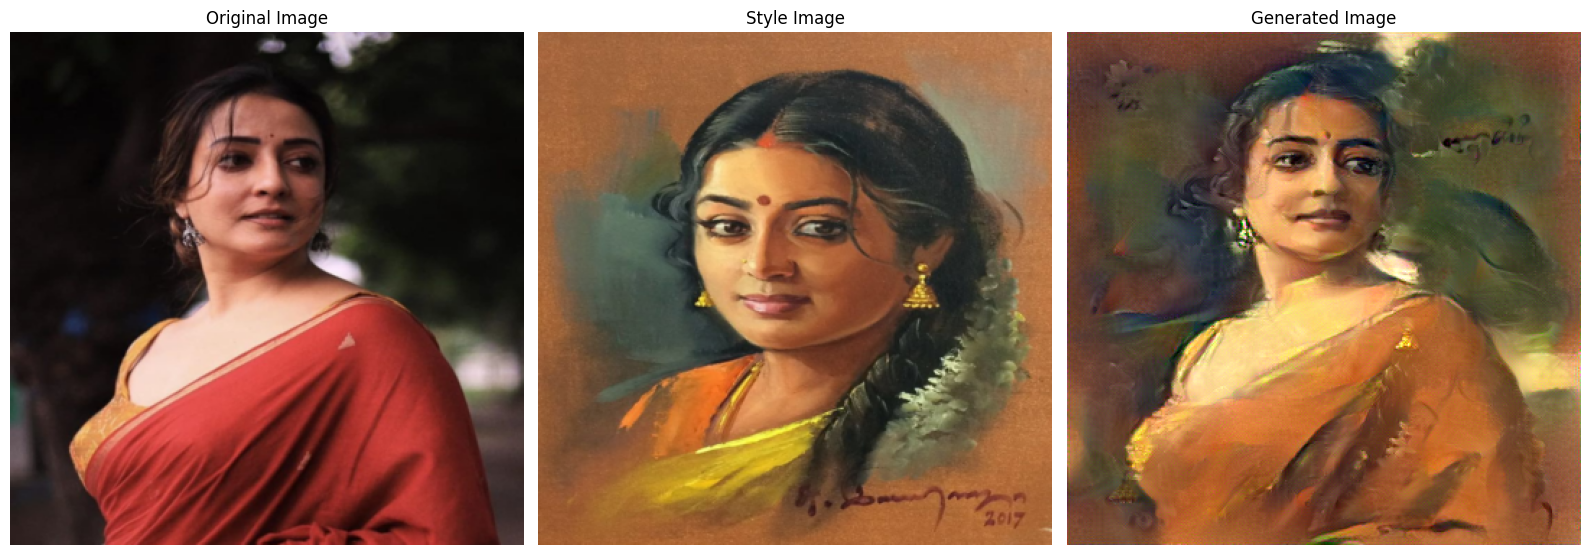

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(16, 16))
ax[0].imshow(original_image.squeeze(0).permute(1, 2, 0).cpu())
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(style_image.squeeze(0).permute(1, 2, 0).cpu())
ax[1].set_title("Style Image")
ax[1].axis("off")

ax[2].imshow(generated_image.squeeze(0).permute(1, 2, 0).cpu())
ax[2].set_title("Generated Image")
ax[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# !rm -r "output"